In [9]:
import sys, os
import numpy as np
import sys, os
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as pl
import yaml
import readfof
import sys, os
import numpy as np
import pickle as pk 
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL
import yaml
import galactic_wavelets as gw
import torch

def setup_hod(hmass, nbar=4e-4, satfrac=0.2, bs=1000, alpha_fid=0.76):
    numdhalos = len(hmass)/bs**3
    numhalos_nbarf = int(nbar * bs**3 * (1-satfrac))
    mcut = hmass[:numhalos_nbarf][-1]
    nsat = satfrac * nbar * bs**3
    mdiff = (hmass - mcut + mcut*1e-3)[:numhalos_nbarf] ** alpha_fid
    msum = mdiff.sum()/nsat
    m1 = msum**(1/alpha_fid)
    return mcut, m1



def calc_summary(isim):
    ldir = '/mnt/home/spandey/ceph/CHARM/data/halo_cats_charm_truth/'
    LH_cosmo_val_file = '/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'

    sdir_stats = '/mnt/home/spandey/ceph/CHARM/data/summary_stats_charm_truth/'
    savefname = sdir_stats + '/summary_stats_weighted_rsd_' + str(isim) + '_nbar_4en4.pk'
    if os.path.exists(savefname):
        print(f"File exists: {savefname}")
        return
    else:

        df = pk.load(open(ldir + f'halo_cat_pos_vel_LH_{isim}.pk', 'rb'))

        lgmass = df['lgmass_mock']
        mass_argsort = np.flip(np.argsort(lgmass))
        lgmass_sort = lgmass[mass_argsort]

        sigma_lgM = 0.2
        alpha_sat = 0.76
        nbar = 4e-4
        sat_frac = 0.2

        ns_h = 128
        grid = ns_h    #the 3D field will have grid x grid x grid voxels
        BoxSize = 1000.0 #Mpc/h ; size of box

        kmax = 0.32
        nk = 16
        threads = 10

        dx = BoxSize/grid # Mpc/h
        device = 0
        J = 3
        Q = 4
        kc = 2*np.pi/3 # Cutoff frequency of the mother wavelet (in px^-1 units)
        moments = [1/2, 1, 2]
        MAS     = 'NGP'  #mass-assigment scheme
        verbose = False   #print information on progress


        mcut, m1 = setup_hod(10**lgmass_sort, nbar=nbar, satfrac=sat_frac, bs=BoxSize, alpha_fid=alpha_sat)
        lgMmin_cut = np.log10(mcut) - sigma_lgM/2.
        Mmin_Pk, Mmax_Pk = lgMmin_cut, 16.0

        saved = pk.load(open(ldir + f'halo_cat_pos_vel_LH_{isim}.pk', 'rb'))
        # saved = {'pos_h_truth': pos_h_truth, 'lgMass_truth': lgMass_truth, 'pos_h_mock': pos_h_mock, 'lgMass_mock': lgMass_mock, 'cosmo':cosmo_val_all_test[0,0,0,0,:]}
        pos_h_truth = saved['pos_truth']
        lgMass_truth = saved['lgmass_truth']
        pos_h_mock = saved['pos_mock']
        lgMass_mock = saved['lgmass_mock']

        pos_h_rsd_mock = saved['pos_rsdx_mock']
        pos_h_rsd_truth = saved['pos_rsdx_truth']        

        LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)
        cosmo = LH_cosmo_val_all[isim]

        saved_j = {}
        # Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]

        M1 = np.log10(m1)
        alpha = alpha_sat

        pos_type = ['real', 'rsd']
        for pos in pos_type:
            if pos == 'real':
                pos_mock_here = pos_h_mock
                pos_truth_here = pos_h_truth
            elif pos == 'rsd':
                pos_mock_here = pos_h_rsd_mock
                pos_truth_here = pos_h_rsd_truth
            else:
                raise ValueError(f"Unknown pos type: {pos}")
            indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
            mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
            pos_truth2 = (pos_truth_here[indsel_Pk_truth,...]).astype(np.float32)
            W_truth = (10**lgMass_truth[indsel_Pk_truth]/10**M1)**(alpha)
            # MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS, W=10**((lgMass_truth[indsel_Pk_truth]- Mmax_Pk)))
            MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS, W=W_truth)
            mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
            Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=threads)

            indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
            mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
            pos_mock = (pos_mock_here[indsel_Pk_mock,...]).astype(np.float32)
            W_mock = (10**lgMass_mock[indsel_Pk_mock]/10**M1)**(alpha)
            # MASL.MA(pos_mock, mesh_mock, BoxSize, MAS, W=10**((lgMass_mock[indsel_Pk_mock]- Mmax_Pk)))
            MASL.MA(pos_mock, mesh_mock, BoxSize, MAS, W=W_mock)
            mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
            Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=threads)

            indk_sel = np.where((Pk_truth2.k3D >= 0.01) & (Pk_truth2.k3D <= kmax))[0]
            Pkmock_sel = Pk_mock.Pk[indk_sel,:]
            Pktruth_sel = Pk_truth2.Pk[indk_sel,:]

            k_Pk = Pk_truth2.k3D[indk_sel]

            len_k_sel = len(indk_sel)
            ds_fac = len_k_sel//nk
            Pk_mock_ds = Pkmock_sel[::ds_fac]
            Pk_truth_ds = Pktruth_sel[::ds_fac]
            k_Pk_ds = k_Pk[::ds_fac]

            saved_j[pos + '_Pk_truth_weighted'] = Pk_truth_ds
            saved_j[pos + '_Pk_mock_weighted'] = Pk_mock_ds
            saved_j[pos + '_k_Pk_weighted'] = k_Pk_ds

            BoxSize = 1000.0 #Size of the density field in Mpc/h
            # threads = 1
            theta   = np.linspace(0.1, np.pi-0.1, 8) #array with the angles between k1 and k2
            saved_j['theta'] = theta

            k1 = 0.08
            k2 = 0.08
            BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
            Bk_truth_k0p06  = BBk.B     #bispectrum
            Qk_truth_k0p06  = BBk.Q     #reduced bispectrum
            BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
            Bk_mock_k0p06  = BBk.B     #bispectrum
            Qk_mock_k0p06  = BBk.Q     #reduced bispectrum

            saved_j[pos + '_Bk_truth_k0p06_weighted'] = Bk_truth_k0p06
            saved_j[pos + '_Qk_truth_k0p06_weighted'] = Qk_truth_k0p06
            saved_j[pos + '_Bk_mock_k0p06_weighted'] = Bk_mock_k0p06
            saved_j[pos + '_Qk_mock_k0p06_weighted'] = Qk_mock_k0p06

            k1 = 0.16
            k2 = 0.16
            BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
            Bk_truth_k0p2  = BBk.B     #bispectrum
            Qk_truth_k0p2  = BBk.Q     #reduced bispectrum
            BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
            Bk_mock_k0p2  = BBk.B     #bispectrum
            Qk_mock_k0p2  = BBk.Q     #reduced bispectrum

            saved_j[pos + '_Bk_truth_k0p2_weighted'] = Bk_truth_k0p2
            saved_j[pos + '_Qk_truth_k0p2_weighted'] = Qk_truth_k0p2
            saved_j[pos + '_Bk_mock_k0p2_weighted'] = Bk_mock_k0p2
            saved_j[pos + '_Qk_mock_k0p2_weighted'] = Qk_mock_k0p2


            k1 = 0.32
            k2 = 0.32
            BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
            Bk_truth_k0p3  = BBk.B     #bispectrum
            Qk_truth_k0p3  = BBk.Q     #reduced bispectrum
            BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
            Bk_mock_k0p3  = BBk.B     #bispectrum
            Qk_mock_k0p3  = BBk.Q     #reduced bispectrum

            saved_j[pos + '_Bk_truth_k0p3_weighted'] = Bk_truth_k0p3
            saved_j[pos + '_Qk_truth_k0p3_weighted'] = Qk_truth_k0p3
            saved_j[pos + '_Bk_mock_k0p3_weighted'] = Bk_mock_k0p3
            saved_j[pos + '_Qk_mock_k0p3_weighted'] = Qk_mock_k0p3


            df = torch.from_numpy(mesh_truth2).to(device)
            df_shape = df.shape
            N = df_shape[0]
            wst_op = gw.ScatteringOp(df_shape, J, Q,
                                    moments=moments,
                                    kc=kc,
                                    scattering=True,
                                    device=device)
            s0_truth, s1_truth, s2_truth = wst_op(df)

            s0_truth = s0_truth.cpu().numpy()
            s1_truth = s1_truth.cpu().numpy().flatten()
            s2_truth = s2_truth.cpu().numpy().flatten()

            saved_j[pos + 's0_truth_weighted'] = s0_truth
            saved_j[pos + 's1_truth_weighted'] = s1_truth
            saved_j[pos + 's2_truth_weighted'] = s2_truth


            df = torch.from_numpy(mesh_mock).to(device)
            df_shape = df.shape
            N = df_shape[0]
            wst_op = gw.ScatteringOp(df_shape, J, Q,
                                    moments=moments,
                                    kc=kc,
                                    scattering=True,
                                    device=device)
            s0_mock, s1_mock, s2_mock = wst_op(df)

            s0_mock = s0_mock.cpu().numpy()
            s1_mock = s1_mock.cpu().numpy().flatten()
            s2_mock = s2_mock.cpu().numpy().flatten()

            saved_j[pos + '_s0_mock_weighted'] = s0_mock
            saved_j[pos + '_s1_mock_weighted'] = s1_mock
            saved_j[pos + '_s2_mock_weighted'] = s2_mock

            summary_concat_mock_all_weighted = np.concatenate((Pk_mock_ds.flatten(), Bk_mock_k0p06, Bk_mock_k0p2, Bk_mock_k0p3, s0_mock, s1_mock[::4], s2_mock[::6]))
            summary_concat_truth_all_weighted = np.concatenate((Pk_truth_ds.flatten(), Bk_truth_k0p06, Bk_truth_k0p2, Bk_truth_k0p3, s0_truth, s1_truth[::4], s2_truth[::6]))

            saved_j[pos + '_summary_concat_mock_all_weighted'] = summary_concat_mock_all_weighted
            saved_j[pos + '_summary_concat_truth_all_weighted'] = summary_concat_truth_all_weighted

        saved_j['cosmo'] = cosmo        

        pk.dump(saved_j, open(savefname, 'wb'))
        print('saved_with_weighting')





In [10]:
# calc_summary(0)





Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.13 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.13 seconds

Computing bispectrum of the field...
Time to compute bispectrum = 1.62

Computing bispectrum of the field...
Time to compute bispectrum = 1.62

Computing bispectrum of the field...
Time to compute bispectrum = 1.63

Computing bispectrum of the field...
Time to compute bispectrum = 1.61

Computing bispectrum of the field...
Time to compute bispectrum = 1.63

Computing bispectrum of the field...
Time to compute bispectrum = 1.64
Computing wavelets...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Computing S2 coefficients...
Done!
Computing wavelets...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Computing S2 coefficients...
Done!

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 

In [13]:
isim = 0
sdir_stats = '/mnt/home/spandey/ceph/CHARM/data/summary_stats_charm_truth/'
savefname = sdir_stats + '/summary_stats_weighted_rsd_' + str(isim) + '_nbar_4en4.pk'
df = pk.load(open(savefname, 'rb'))
real_summary_concat_mock = df['real_summary_concat_mock_all_weighted']
rsd_summary_concat_mock = df['rsd_summary_concat_mock_all_weighted']

real_summary_concat_truth = df['real_summary_concat_truth_all_weighted']
rsd_summary_concat_truth = df['rsd_summary_concat_truth_all_weighted']




In [20]:
df['real_Pk_truth_weighted'][:,2] 


array([ 73008.37708185,  33041.16909936, -10430.37845795,    815.55764114,
         6634.36967808,    232.36669074,   1354.59288277,   2770.29764816,
        -1239.0880918 ,  -2244.67830175,  -1947.45124488,   -563.73893087,
         -702.12019178,    262.32285423,   1105.35915419,    492.61050114,
          770.84103159])

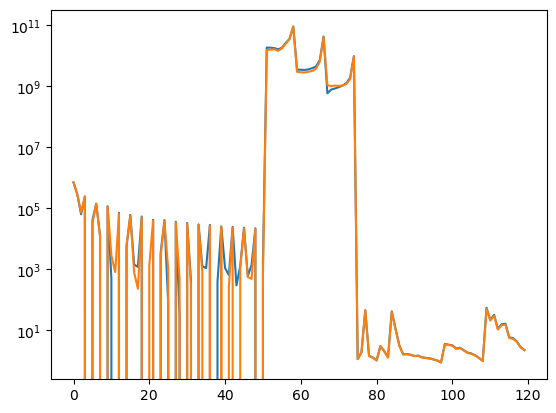

In [15]:
pl.figure()
pl.plot(real_summary_concat_mock, label='real_mock')
pl.plot(real_summary_concat_truth, label='real_truth')
pl.yscale('log')


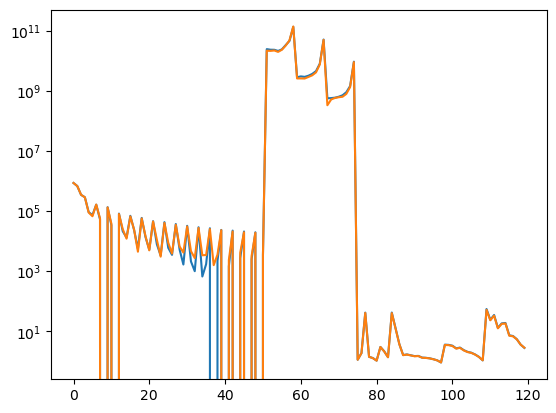

In [16]:
pl.figure()
pl.plot(rsd_summary_concat_mock, label='real_mock')
pl.plot(rsd_summary_concat_truth, label='real_truth')
pl.yscale('log')
